<a href="https://colab.research.google.com/github/mateuszrajca69/r/blob/main/08_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **A regression example**

Common type of machine learning problem is "regression", which consists of predicting a continuous value instead of a discrete label. For instance, predicting the temperature tomorrow, given meteorological data, or predicting the time that a software project will take to complete, given its specifications.



In [ ]:

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt



In [ ]:
# install optuna
! pip install optuna

     |████████████████████████████████| 266kB 12.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 36.7MB/s 
     |████████████████████████████████| 81kB 11.8MB/s 
     |████████████████████████████████| 81kB 12.7MB/s 
     |████████████████████████████████| 133kB 55.9MB/s 
     |████████████████████████████████| 112kB 57.0MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=995ca84a34ff5804a886d775825a23214b9c8f2c529458cf58c4e55331e1e707
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/64b0ec6b964f89c0695a9dc6db6f851d0b54c5381a5c9cadfb
Successfully built optuna
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13700 sha256=5518753898be0df5ea7dc5374b93d55e1fd92be831963e1d05ba1ab3671b1700
  Stored in directory: /root/.cache/pip/

In [ ]:
import optuna


**1-dimensional data**

In [ ]:
def funct(x):
  return x*x*np.sin(x)+np.log(2*x)

size = 200
low=0
high=12
error=20

XX_train = np.random.uniform(low=low, high=high, size=size)
XX_test = np.random.uniform(low=low, high=high, size=size)
yy_train = funct(XX_train) + np.random.normal(0., error, size)
yy_test = funct(XX_test) + np.random.normal(0., error, size)

print(XX_train.shape, yy_train.shape)

(200,) (200,)


Plot the function and data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log



<function matplotlib.pyplot.show>

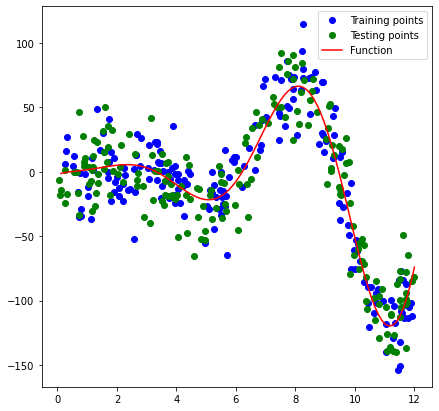

In [ ]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train,yy_train, 'o', color='blue', label='Training points')
plt.plot(XX_test,yy_test, 'o', color='green', label='Testing points')

points = np.linspace(low, high,num=100)
plt.plot(points, funct(points),  color='red', label='Function')
plt.legend()


plt.show


**Preparing the data**

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation. This is easily done in Numpy:


In [ ]:
# Tutaj należy znormalizować dane, i.e. 
# - odjąć średnią
# - podzielić przez odchylenie standardowe

# 
mean = XX_train.mean(axis=0)
XX_train_n = XX_train-mean
std = XX_train_n.std(axis=0)
XX_train_n /= std

# to samo dla x_test
XX_test_n = XX_test - mean
XX_test_n /= std

mean1 = yy_train.mean(axis=0)
yy_train_n = yy_train-mean1
std1 = yy_train_n.std(axis=0)
yy_train_n /= std1

# to samo dla y_test
yy_test_n = yy_test - mean1
yy_test_n /= std1

# A teraz to samo dla yy_train i yy_test
# dopisać to samo dla y

Define neural network

In [ ]:
# Zbudować sieć neuronową, działa: dwie warstwy ukryte, aktywacja relu
from keras import models
from keras import layers



In [ ]:

def objective(trial):
    units = trial.suggest_discrete_uniform('units', 8, 2048, 1)
    dropout = trial.suggest_uniform('dropout', 0, 0.5)
    lr = trial.suggest_float('lr',0.0005, 0.002, log=True)
    act= trial.suggest_categorical('activation',['relu','sigmoid','linear'])

    model0 = Sequential(name='network')
    #.....
    model0.add(layers.Dense(units, activation=act, input_shape=(1,)))
    model0.add(Dropout(dropout))
    model0.add(layers.Dense(units, activation=act))
    model0.add(Dropout(dropout))
    model0.add(layers.Dense(1, activation='linear'))
    # early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50 )
    
    #model0.summary()
    opt=optimizers.RMSprop(lr=lr)
    model0.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=['mse'])
    history = model0.fit(XX_train_n, yy_train_n,
                                     epochs=500,
                                     batch_size=128,
                                     validation_data=(XX_test_n, yy_test_n),
                                     verbose = 0, callbacks=[es])
    results = model0.evaluate(XX_test_n, yy_test_n)
    return results[0]

In [ ]:
study = optuna.create_study()
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )

study.optimize(objective, n_trials=20)

study.best_params 


[I 2020-12-08 09:02:20,237] A new study created in memory with name: no-name-fa8fb262-c14c-4b7d-9d93-e70a67e8bcb1
[I 2020-12-08 09:02:20,240] A new study created in memory with name: no-name-0d0a795f-7e35-4f99-8d15-68ba3ace17d9


7/7 [==============================] - 0s 2ms/step - loss: 0.4333 - mse: 0.4333


[I 2020-12-08 09:02:37,631] Trial 0 finished with value: 0.4332802891731262 and parameters: {'units': 1227.0, 'dropout': 0.17380375790216618, 'lr': 0.0007015071924956261, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.4332802891731262.


Epoch 00445: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1830 - mse: 0.1830


[I 2020-12-08 09:02:46,824] Trial 1 finished with value: 0.18299436569213867 and parameters: {'units': 1359.0, 'dropout': 0.04488649305893727, 'lr': 0.0007605771783184938, 'activation': 'relu'}. Best is trial 1 with value: 0.18299436569213867.


Epoch 00066: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.8803 - mse: 0.8803


[I 2020-12-08 09:02:48,636] Trial 2 finished with value: 0.8802750110626221 and parameters: {'units': 364.0, 'dropout': 0.18306407640570393, 'lr': 0.0008278045437835421, 'activation': 'linear'}. Best is trial 1 with value: 0.18299436569213867.


7/7 [==============================] - 0s 2ms/step - loss: 0.4593 - mse: 0.4593


[I 2020-12-08 09:02:58,362] Trial 3 finished with value: 0.4593106806278229 and parameters: {'units': 396.0, 'dropout': 0.3194048202241112, 'lr': 0.0006134314741018276, 'activation': 'sigmoid'}. Best is trial 1 with value: 0.18299436569213867.


Epoch 00078: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.7876 - mse: 0.7876


[I 2020-12-08 09:03:00,556] Trial 4 finished with value: 0.7875985503196716 and parameters: {'units': 22.0, 'dropout': 0.07684481117891878, 'lr': 0.0007887661081866408, 'activation': 'linear'}. Best is trial 1 with value: 0.18299436569213867.


7/7 [==============================] - 0s 2ms/step - loss: 0.4148 - mse: 0.4148


[I 2020-12-08 09:03:11,541] Trial 5 finished with value: 0.414757639169693 and parameters: {'units': 1786.0, 'dropout': 0.396345411126877, 'lr': 0.0005646169784096245, 'activation': 'sigmoid'}. Best is trial 1 with value: 0.18299436569213867.


Epoch 00304: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2230 - mse: 0.2230


[I 2020-12-08 09:03:17,891] Trial 6 finished with value: 0.22299791872501373 and parameters: {'units': 1062.0, 'dropout': 0.4675230430420711, 'lr': 0.0016505103724656464, 'activation': 'relu'}. Best is trial 1 with value: 0.18299436569213867.


Epoch 00079: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.1144 - mse: 1.1144


[I 2020-12-08 09:03:20,100] Trial 7 finished with value: 1.1143513917922974 and parameters: {'units': 1633.0, 'dropout': 0.15746498060150455, 'lr': 0.0011174520679130221, 'activation': 'sigmoid'}. Best is trial 1 with value: 0.18299436569213867.


Epoch 00301: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2127 - mse: 0.2127


[I 2020-12-08 09:03:26,274] Trial 8 finished with value: 0.21269717812538147 and parameters: {'units': 852.0, 'dropout': 0.08091360438686496, 'lr': 0.0014568214737061388, 'activation': 'relu'}. Best is trial 1 with value: 0.18299436569213867.


Epoch 00317: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1766 - mse: 0.1766


[I 2020-12-08 09:03:32,607] Trial 9 finished with value: 0.17662768065929413 and parameters: {'units': 284.0, 'dropout': 0.34513640702591275, 'lr': 0.0006394904804291686, 'activation': 'relu'}. Best is trial 9 with value: 0.17662768065929413.


Epoch 00445: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1822 - mse: 0.1822


[I 2020-12-08 09:03:41,367] Trial 10 finished with value: 0.18222694098949432 and parameters: {'units': 50.0, 'dropout': 0.3073688434046412, 'lr': 0.0011173775554908633, 'activation': 'relu'}. Best is trial 9 with value: 0.17662768065929413.


Epoch 00341: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1854 - mse: 0.1854


[I 2020-12-08 09:03:48,260] Trial 11 finished with value: 0.18543581664562225 and parameters: {'units': 165.0, 'dropout': 0.3026786313416848, 'lr': 0.0011273691391623425, 'activation': 'relu'}. Best is trial 9 with value: 0.17662768065929413.


Epoch 00254: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2300 - mse: 0.2300


[I 2020-12-08 09:03:53,488] Trial 12 finished with value: 0.23000779747962952 and parameters: {'units': 665.0, 'dropout': 0.37687075138392434, 'lr': 0.001319993367082628, 'activation': 'relu'}. Best is trial 9 with value: 0.17662768065929413.


7/7 [==============================] - 0s 2ms/step - loss: 0.2151 - mse: 0.2151


[I 2020-12-08 09:04:03,255] Trial 13 finished with value: 0.21506553888320923 and parameters: {'units': 36.0, 'dropout': 0.48091268067560355, 'lr': 0.0009484265168005127, 'activation': 'relu'}. Best is trial 9 with value: 0.17662768065929413.


Epoch 00215: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2658 - mse: 0.2658


[I 2020-12-08 09:04:08,167] Trial 14 finished with value: 0.2657901346683502 and parameters: {'units': 550.0, 'dropout': 0.2550563308257764, 'lr': 0.001981819449972788, 'activation': 'relu'}. Best is trial 9 with value: 0.17662768065929413.


Epoch 00425: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1719 - mse: 0.1719


[I 2020-12-08 09:04:16,605] Trial 15 finished with value: 0.1718866527080536 and parameters: {'units': 247.0, 'dropout': 0.38781704630157277, 'lr': 0.0005137233527418302, 'activation': 'relu'}. Best is trial 15 with value: 0.1718866527080536.


Epoch 00054: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.7916 - mse: 0.7916


[I 2020-12-08 09:04:18,214] Trial 16 finished with value: 0.7916419506072998 and parameters: {'units': 321.0, 'dropout': 0.41756196921213, 'lr': 0.0005067243636078746, 'activation': 'linear'}. Best is trial 15 with value: 0.1718866527080536.


Epoch 00376: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1732 - mse: 0.1732


[I 2020-12-08 09:04:25,737] Trial 17 finished with value: 0.17317436635494232 and parameters: {'units': 746.0, 'dropout': 0.3548432052856984, 'lr': 0.0006257517218698494, 'activation': 'relu'}. Best is trial 15 with value: 0.1718866527080536.


Epoch 00440: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1807 - mse: 0.1807


[I 2020-12-08 09:04:34,522] Trial 18 finished with value: 0.18073402345180511 and parameters: {'units': 807.0, 'dropout': 0.4469278334439696, 'lr': 0.0005006968550666952, 'activation': 'relu'}. Best is trial 15 with value: 0.1718866527080536.


7/7 [==============================] - 0s 3ms/step - loss: 0.1682 - mse: 0.1682


[I 2020-12-08 09:04:44,373] Trial 19 finished with value: 0.16822639107704163 and parameters: {'units': 611.0, 'dropout': 0.2611887256169342, 'lr': 0.0005053733918446076, 'activation': 'relu'}. Best is trial 19 with value: 0.16822639107704163.


{'activation': 'relu',
 'dropout': 0.2611887256169342,
 'lr': 0.0005053733918446076,
 'units': 611.0}

## Visualizing the Optimization History

In [ ]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

## Visualizing High-dimensional Parameter Relationships

In [ ]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study, params=['units', 'dropout'])

## Visualizing Parameter Relationships

In [ ]:
from optuna.visualization import plot_contour

plot_contour(study)

### Selecting Parameters to Visualize

In [ ]:
plot_contour(study, params=['units', 'dropout'])

## Visualizing Individual Parameters

In [ ]:
from optuna.visualization import plot_slice

plot_slice(study)

### Selecting Parameters to Visualize

In [ ]:
plot_slice(study, params=['units', 'dropout'])

## Visualizing Parameter Importances

In [ ]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

In [ ]:
trial = study.best_trial
units = int(trial.params.get('units'))
dropout = (trial.params.get('dropout'))
print(units)
print(dropout)

In [ ]:
model0 = Sequential(name='network')
    #.....
model0.add(layers.Dense(units, activation='relu', input_shape=(1,)))
model0.add(Dropout(dropout))
model0.add(layers.Dense(units, activation='relu'))
model0.add(Dropout(dropout))
model0.add(layers.Dense(1, activation='linear'))
# early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50 )
    
#model0.summary()
opt=optimizers.RMSprop(lr=0.001)
model0.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=['mse'])
history = model0.fit(XX_train_n, yy_train_n,
                                     epochs=500,
                                     batch_size=128,
                                     validation_data=(XX_test_n, yy_test_n),
                                     verbose = 0, callbacks=[es])
results = model0.evaluate(XX_test_n, yy_test_n)

Plot loss

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('Error ')
  plt.legend()
  plt.grid(True)

plot_loss(history)


Evaluate neural network

In [ ]:
results = model0.evaluate(XX_test_n, yy_test_n)

print('loss test data: ', results[0])
print('mse test data: ', results[1])

results = model0.evaluate(XX_train_n, yy_train_n)

print('loss train data: ', results[0])
print('mse train data: ', results[1])

Plot results

In [ ]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train_n,yy_train_n, 'o', color='blue', label='Training points')
plt.plot(XX_test_n,yy_test_n, 'o', color='green', label='Testing points')

points = np.linspace(min(XX_test_n), max(XX_test_n),num=100)
plt.plot(points, (funct(points*std+mean)-mean1)/std1,  color='red', label='Function')

plt.plot(points, model0.predict(points),  color='orange', label='Neural net')


plt.legend()


plt.show